<a href="https://colab.research.google.com/github/ArifAygun/Iron-Ore-Froth-Flotation-Quality-Prediction/blob/main/AA_Graduate_Project_2_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quality Prediction of Iron Ore Mining Flotation Process - Part:2**

### **Import Libraries and Modules**

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
import random
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### **Import Dataset**

In [47]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Flotation/

flotation = pd.read_csv('flotation_manipulated.csv')
flotation.head().T

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Flotation


,0,1,2,3,4
iron_feed,55.200000,55.200000,55.200000,55.200000,55.200000
silica_feed,16.980000,16.980000,16.980000,16.980000,16.980000
starch_flow,323.277098,313.325639,347.948294,334.142022,340.935100
amina_flow,578.786678,537.219661,591.906744,593.170106,619.710806
pulp_flow,398.753368,399.871822,398.763806,399.866983,399.615089
pulp_pH,10.113621,10.129944,10.048444,9.918389,9.745722
pulp_density,1.729598,1.667556,1.733000,1.730944,1.765889
airflow,264.929678,264.490111,264.647722,264.573311,264.559433
level,452.624362,450.767561,452.043033,493.578506,551.274806
iron_conc,66.910000,67.060000,66.970000,66.750000,66.630000


## **5. Machine Learning Models**

### **5.1. Splitting Dataset**

**Split Dataset as X and y**

In [48]:
X = flotation.drop(['silica_conc', 'iron_conc'], axis=1)
y_Si = flotation['silica_conc']
y_Fe = flotation['iron_conc']

print("Shape of X:", X.shape)
print("Shape of y_Si:", y_Si.shape)
print("Shape of y_Fe:", y_Fe.shape)


Shape of X: (4097, 9)
Shape of y_Si: (4097,)
Shape of y_Fe: (4097,)


### **5.2. Models For Silica Concentrate**

**Split into train, validation, and test set**

In [49]:
X_train, X_val, y_train, y_val = train_test_split(X, y_Si, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(3277, 9) (410, 9) (410, 9)


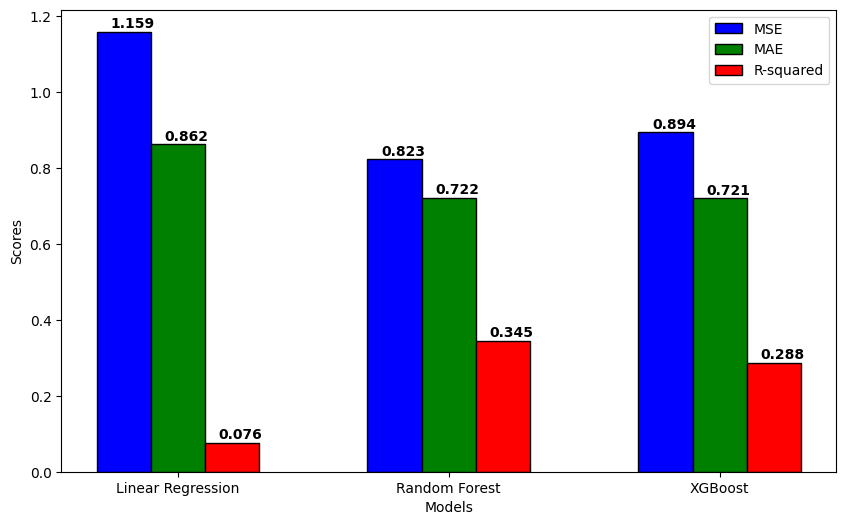

Mean Squared Error (MSE):
Linear Regression: 1.159
Random Forest: 0.823
XGBoost: 0.894

Mean Absolute Error (MAE):
Linear Regression: 0.862
Random Forest: 0.722
XGBoost: 0.721

R-squared (R^2):
Linear Regression: 0.076
Random Forest: 0.345
XGBoost: 0.288


In [50]:
# Creating pipelines for each model
linear_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor())
])

xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', xgb.XGBRegressor())
])

# Fitting the pipelines to the training data
linear_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)
xgb_pipeline.fit(X_train, y_train)

# Predicting on the validation data for each model
linear_val_pred = linear_pipeline.predict(X_val)
rf_val_pred = rf_pipeline.predict(X_val)
xgb_val_pred = xgb_pipeline.predict(X_val)

# Calculating evaluation metrics for each model
linear_mse = mean_squared_error(y_val, linear_val_pred)
linear_mae = mean_absolute_error(y_val, linear_val_pred)
linear_r2 = r2_score(y_val, linear_val_pred)

rf_mse = mean_squared_error(y_val, rf_val_pred)
rf_mae = mean_absolute_error(y_val, rf_val_pred)
rf_r2 = r2_score(y_val, rf_val_pred)

xgb_mse = mean_squared_error(y_val, xgb_val_pred)
xgb_mae = mean_absolute_error(y_val, xgb_val_pred)
xgb_r2 = r2_score(y_val, xgb_val_pred)

# Collecting the evaluation metric scores
mse_scores = [linear_mse, rf_mse, xgb_mse]
mae_scores = [linear_mae, rf_mae, xgb_mae]
r2_scores = [linear_r2, rf_r2, xgb_r2]


bar_width = 0.2
r1 = np.arange(len(mse_scores))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(10, 6))

plt.bar(r1, mse_scores, color='b', width=bar_width, edgecolor='black', label='MSE')
plt.bar(r2, mae_scores, color='g', width=bar_width, edgecolor='black', label='MAE')
plt.bar(r3, r2_scores, color='r', width=bar_width, edgecolor='black', label='R-squared')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.xticks([r + bar_width for r in range(len(mse_scores))], ['Linear Regression', 'Random Forest', 'XGBoost'])

plt.legend()

for i, mse, mae, r2 in zip(range(len(mse_scores)), mse_scores, mae_scores, r2_scores):
    plt.text(i - 0.05, mse + 0.01, f'{mse:.3f}', color='black', fontweight='bold')
    plt.text(i + bar_width - 0.05, mae + 0.01, f'{mae:.3f}', color='black', fontweight='bold')
    plt.text(i + 2 * bar_width - 0.05, r2 + 0.01, f'{r2:.3f}', color='black', fontweight='bold')

plt.show()

# Displaying the evaluation metric scores as text
print(f"Mean Squared Error (MSE):")
for model, mse in zip(['Linear Regression', 'Random Forest', 'XGBoost'], mse_scores):
    print(f"{model}: {mse:.3f}")

print(f"\nMean Absolute Error (MAE):")
for model, mae in zip(['Linear Regression', 'Random Forest', 'XGBoost'], mae_scores):
    print(f"{model}: {mae:.3f}")

print(f"\nR-squared (R^2):")
for model, r2 in zip(['Linear Regression', 'Random Forest', 'XGBoost'], r2_scores):
    print(f"{model}: {r2:.3f}")


- Mean Squared Error (MSE): The Random Forest model achieved the lowest MSE, followed by XGBoost, and Linear Regression. This indicates that the Random Forest model has the best overall performance in terms of minimizing the squared differences between the predicted and actual values.

- Mean Absolute Error (MAE): The Random Forest model outperforms the other models. XGBoost closely follows, while Linear Regression has the highest MAE. The lower the MAE, the better the model's ability to predict the target variable accurately on average.

- R-squared (R^2): The R-squared values measure the proportion of the variance in the target variable that can be explained by the predictors. The Random Forest model achieved the highest R-squared value 0.345, indicating that it explains approximately 34.5% of the variance in the target variable. XGBoost follows with an R-squared value of 0.288, while Linear Regression has the lowest R-squared value of 0.076. A higher R-squared value suggests a better fit of the model to the data.

- Finally, it appears that the Random Forest model still performs the best among the three models, followed by XGBoost. Linear Regression continues to have the weakest performance in terms of predictive accuracy and explaining the variance in the target variable. However, it's important to note that further analysis, tuning, and consideration of other factors are necessary to make a final determination on the most suitable model for the given task.

### **5.2. Models For Iron Concentrate**

**Split into train, validation, and test set**

In [51]:
X_train, X_val, y_train, y_val = train_test_split(X, y_Fe, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(3277, 9) (410, 9) (410, 9)


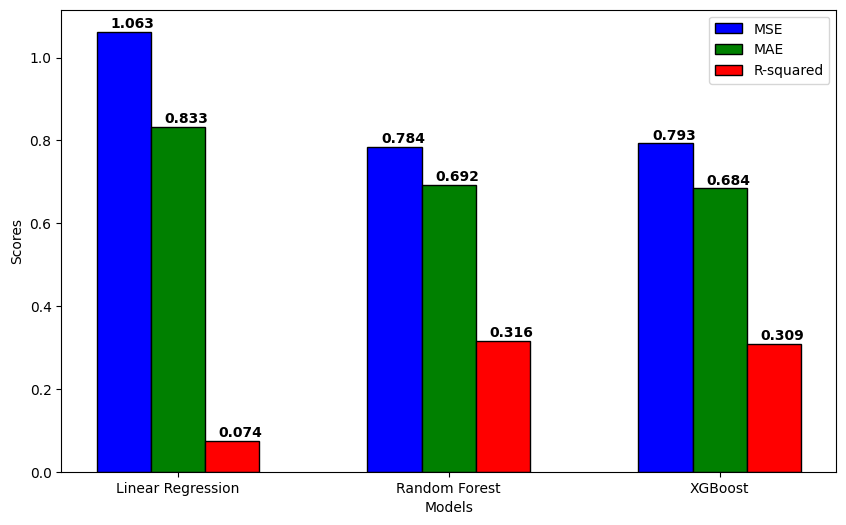

Mean Squared Error (MSE):
Linear Regression: 1.063
Random Forest: 0.784
XGBoost: 0.793

Mean Absolute Error (MAE):
Linear Regression: 0.833
Random Forest: 0.692
XGBoost: 0.684

R-squared (R^2):
Linear Regression: 0.074
Random Forest: 0.316
XGBoost: 0.309


In [52]:
# Creating pipelines for each model
linear_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor())
])

xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', xgb.XGBRegressor())
])

# Fitting the pipelines to the training data
linear_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)
xgb_pipeline.fit(X_train, y_train)

# Predicting on the validation data for each model
linear_val_pred = linear_pipeline.predict(X_val)
rf_val_pred = rf_pipeline.predict(X_val)
xgb_val_pred = xgb_pipeline.predict(X_val)

# Calculating evaluation metrics for each model
linear_mse = mean_squared_error(y_val, linear_val_pred)
linear_mae = mean_absolute_error(y_val, linear_val_pred)
linear_r2 = r2_score(y_val, linear_val_pred)

rf_mse = mean_squared_error(y_val, rf_val_pred)
rf_mae = mean_absolute_error(y_val, rf_val_pred)
rf_r2 = r2_score(y_val, rf_val_pred)

xgb_mse = mean_squared_error(y_val, xgb_val_pred)
xgb_mae = mean_absolute_error(y_val, xgb_val_pred)
xgb_r2 = r2_score(y_val, xgb_val_pred)

# Collecting the evaluation metric scores
mse_scores = [linear_mse, rf_mse, xgb_mse]
mae_scores = [linear_mae, rf_mae, xgb_mae]
r2_scores = [linear_r2, rf_r2, xgb_r2]


bar_width = 0.2
r1 = np.arange(len(mse_scores))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]


plt.figure(figsize=(10, 6))
plt.bar(r1, mse_scores, color='b', width=bar_width, edgecolor='black', label='MSE')
plt.bar(r2, mae_scores, color='g', width=bar_width, edgecolor='black', label='MAE')
plt.bar(r3, r2_scores, color='r', width=bar_width, edgecolor='black', label='R-squared')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.xticks([r + bar_width for r in range(len(mse_scores))], ['Linear Regression', 'Random Forest', 'XGBoost'])
plt.legend()

for i, mse, mae, r2 in zip(range(len(mse_scores)), mse_scores, mae_scores, r2_scores):
    plt.text(i - 0.05, mse + 0.01, f'{mse:.3f}', color='black', fontweight='bold')
    plt.text(i + bar_width - 0.05, mae + 0.01, f'{mae:.3f}', color='black', fontweight='bold')
    plt.text(i + 2 * bar_width - 0.05, r2 + 0.01, f'{r2:.3f}', color='black', fontweight='bold')

plt.show()

# Displaying the evaluation metric scores as text
print(f"Mean Squared Error (MSE):")
for model, mse in zip(['Linear Regression', 'Random Forest', 'XGBoost'], mse_scores):
    print(f"{model}: {mse:.3f}")

print(f"\nMean Absolute Error (MAE):")
for model, mae in zip(['Linear Regression', 'Random Forest', 'XGBoost'], mae_scores):
    print(f"{model}: {mae:.3f}")

print(f"\nR-squared (R^2):")
for model, r2 in zip(['Linear Regression', 'Random Forest', 'XGBoost'], r2_scores):
    print(f"{model}: {r2:.3f}")

- Mean Squared Error (MSE): The Random Forest model achieved the lowest MSE, followed closely by XGBoost, while Linear Regression had an MSE. This indicates that both Random Forest and XGBoost have better overall performance in terms of minimizing the squared differences between the predicted and actual values compared to Linear Regression.

- Mean Absolute Error (MAE): The XGBoost model actually has the lowest MAE value, indicating better predictive accuracy compared to Random Forest with an MAE. Linear Regression has the highest MAE, suggesting the least accurate predictions among the three models.

- R-squared (R^2): The R-squared values measure the proportion of the variance in the target variable that can be explained by the predictors. In this case, both Random Forest and XGBoost models achieved higher R-squared values compared to Linear Regression. A higher R-squared value suggests a better fit of the model to the data.

- Finally, it appears that both Random Forest and XGBoost models perform better than Linear Regression in terms of predictive accuracy and explaining the variance in the target variable. Random Forest has slightly better performance in terms of MSE and R-squared compared to XGBoost. However, it's important to note that further analysis, tuning, and consideration of other factors are necessary to make a final determination on the most suitable model for the given task.